In [16]:
import numpy as np
import pandas as pd
import os
os.getcwd()

'C:\\Users\\DeLL'

In [21]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
GLOVE_DIR = 'archive/glove.6B.300d.txt'

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data preparing

train_data = list(df_train.text)
train_labels = list(df_train.target)

tokenizer = Tokenizer(num_words=10000) # Only 10000 most met words
tokenizer.fit_on_texts(train_data)
sequences = tokenizer.texts_to_sequences(train_data)

train_data = pad_sequences(sequences, maxlen=100) # Only 100 words in one text
train_labels = np.array(train_labels)


In [24]:
embedding_index = {}

with open(GLOVE_DIR,'r', encoding='utf-8') as file: # Preparing glove
    for line in file:
        values = line.split()
        key = values[0]
        value = values[1:]
        embedding_index[key] = np.array(value, dtype=np.float64)
        
        
embedding_matrix = np.zeros((10000, 300)) # 10000 - num_words, 100 - length of sequence
for word, i in tokenizer.word_index.items():
    if i < 10000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [37]:
import tensorflow as tf
from tensorflow.keras import losses, optimizers, metrics
from tensorflow.keras.layers import Dense, Embedding, Flatten

model = tf.keras.models.Sequential([
    Embedding(10000, 300, input_length=100),
    Flatten(),
    Dense(32, activation=tf.nn.relu),
    Dense(1, activation=tf.nn.sigmoid),
])

model.layers[0].set_weights([embedding_matrix]) # Add glove to our model
model.layers[0].trainable = False # Freeze embedding layer

model.compile(
    loss = losses.binary_crossentropy,
    optimizer = optimizers.RMSprop(lr=0.001),
    metrics = ['accuracy'],
)

model.compile(
    loss='mean_squared_error',
    optimizer='sgd',
    metrics=[metrics.mae,metrics.categorical_accuracy, tf.keras.metrics.Accuracy(),
             tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
             tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives(),
             tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
)


history = model.fit(
    train_data, train_labels,validation_split=0.2,
    validation_data = [validation_data, validation_labels],
    batch_size = 32, 
    epochs = 10,
)

Epoch 1/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2116 - mean_absolute_error: 0.4431 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - precision: 0.6791 - recall: 0.4832 - true_positives: 1238.0000 - true_negatives: 2943.0000 - false_positives: 585.0000 - false_negatives: 1324.0000 - val_loss: 0.1846 - val_mean_absolute_error: 0.4029 - val_categorical_accuracy: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7858 - val_recall: 0.6573 - val_true_positives: 466.0000 - val_true_negatives: 687.0000 - val_false_positives: 127.0000 - val_false_negatives: 243.0000
Epoch 2/10
191/191 [==============================] - 1s 7ms/step - loss: 0.1733 - mean_absolute_error: 0.3824 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - precision: 0.7885 - recall: 0.6358 - true_positives: 1629.0000 - true_negatives: 3091.0000 - false_positives: 437.0000 - false_negatives: 933.0000 - val_loss: 0.1689 - val_mean_absolute_error: 0.3667 - val_categorical_accuracy: 1.0

In [38]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                960032    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 3,960,065
Trainable params: 960,065
Non-trainable params: 3,000,000
_________________________________________________________________


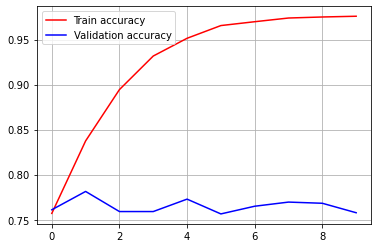

In [30]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], 'r-', label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'b-', label='Validation accuracy')
plt.legend()
plt.grid()
plt.show()


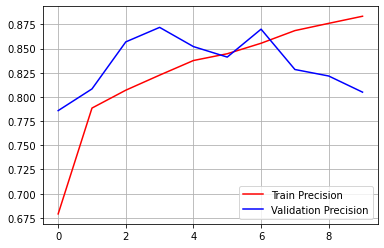

In [40]:
plt.plot(history.history['precision'], 'r-', label='Train Precision')
plt.plot(history.history['val_precision'], 'b-', label='Validation Precision')
plt.legend()
plt.grid()
plt.show()

In [44]:
print("confusion matrix for training set:")


print("[",sum(history.history['true_positives'])/len(history.history['true_positives']),",", sum(history.history['false_positives'])/len(history.history['false_positives']),"]")

print("[",sum(history.history['false_negatives'])/len(history.history['false_negatives']),",",sum(history.history['true_negatives'])/len(history.history['true_negatives']),"]")

confusion matrix for training set:
[ 1769.3 , 364.3 ]
[ 792.7 , 3163.7 ]


In [45]:
print("confusion matrix for validation set:")


print("[",sum(history.history['val_true_positives'])/len(history.history['val_true_positives']),",", sum(history.history['val_false_positives'])/len(history.history['val_false_positives']),"]")

print("[",sum(history.history['val_false_negatives'])/len(history.history['val_false_negatives']),",",sum(history.history['val_true_negatives'])/len(history.history['val_true_negatives']),"]")

confusion matrix for validation set:
[ 468.6 , 94.8 ]
[ 240.4 , 719.2 ]
